## ??

Kevin J. Walchko
created 17 Aug 2017

---




## References

- [Official OpenCV python tutorials](http://docs.opencv.org/3.1.0/db/d27/tutorial_py_table_of_contents_feature2d.html)
- [Image Segmentation](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html#watershed)

## Setup

In [54]:
%matplotlib inline 

import cv2         # opencv itself
import numpy as np # matrix manipulations

from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
import pylab                                   # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 18.0) # this controls figure size in the notebook

input_image=cv2.imread('dnd.jpg')


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

## Image Segmentation with Watershed Algorithm

Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. You start filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. Then the barriers you created gives you the segmentation result. This is the “philosophy” behind the watershed. You can visit the [CMM](http://cmm.ensmp.fr/~beucher/wtshed.html) webpage on watershed to understand it with the help of some animations.

But this approach gives you oversegmented result due to noise or any other irregularities in the image. So OpenCV implemented a marker-based watershed algorithm where you specify which are all valley points are to be merged and which are not. It is an interactive image segmentation. What we do is to give different labels for our object we know. Label the region which we are sure of being the foreground or object with one color (or intensity), label the region which we are sure of being background or non-object with another color and finally the region which we are not sure of anything, label it with 0. That is our marker. Then apply watershed algorithm. Then our marker will be updated with the labels we gave, and the boundaries of objects will have a value of -1.

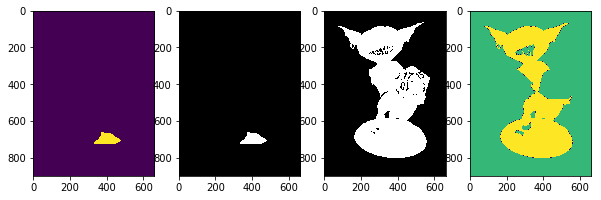

In [50]:
# img = cv2.imread('coins.jpg')
img = cv2.imread('dnd.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
# sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

# boundries are marked as -1
markers = cv2.watershed(img,markers)
# img[markers == -1] = [255,0,0]

plt.subplot(1,4,1)
plt.imshow(sure_fg)

plt.subplot(1,4,2)
plt.imshow(sure_fg, cmap='gray')

plt.subplot(1,4,3)
plt.imshow(thresh, cmap='gray')

plt.subplot(1,4,4)
plt.imshow(markers)

len(markers)==900


ValueError: num must be 1 <= num <= 4, not 5

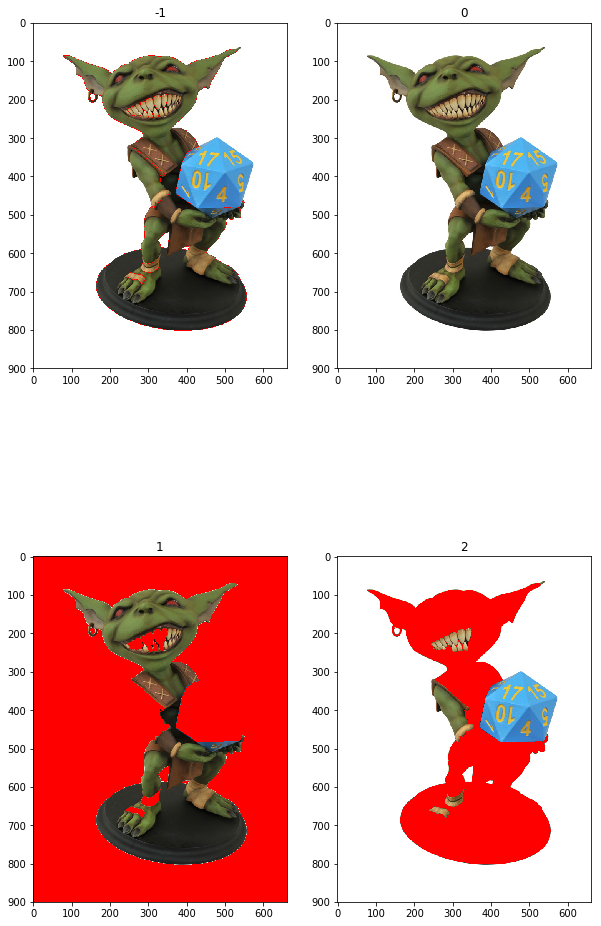

In [55]:
markers = cv2.watershed(img,markers)
print('len(markers)=={}'.format(len(markers)))
# img[markers == 1] = [255,0,0]

max_marker = 4
for i in range(-1, max_marker):
    cimg = img.copy()
    cimg[markers == i] = [255,0,0]
    plt.subplot(2, max_marker//2, i+2)
    plt.imshow(cimg)
    plt.title(i)